In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def openFile(path):
    #param path: path/to/file.ext (str)
    #Returns contents of file (str)
    with open(path) as file:
        data = file.read()
    return data
imdb_data = openFile('imdb_labelled.txt')
amzn_data = openFile('amazon_cells_labelled.txt')
yelp_data = openFile('yelp_labelled.txt')
datasets = [imdb_data, amzn_data, yelp_data]

combined_dataset = []
for dataset in datasets:
    combined_dataset.extend(dataset.split('\n'))
    
dataset = [sample.split('\t') for sample in combined_dataset]

In [3]:
df = pd.DataFrame(data=dataset, columns=['Reviews', 'Labels'])
df = df[df["Labels"].notnull()]

In [4]:
df.head()

,Reviews,Labels
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [5]:
df['Labels'].value_counts()

0    1500
1    1500
Name: Labels, dtype: int64

In [6]:
df.isna().sum()

Reviews    0
Labels     0
dtype: int64

In [7]:
df.duplicated().sum()

17

In [8]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [9]:
#Handling Special Characters
def normalize_text(text):
    text = text.lower()
    # get rid of urls
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # get rid of non words and extra spaces
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

In [10]:
def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [11]:
def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [12]:
def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [13]:
from sklearn.preprocessing import OneHotEncoder
X = df["Reviews"]
y = df['Labels']

one = OneHotEncoder()
y = one.fit_transform(np.asarray(y).reshape(-1,1)).toarray()

In [14]:
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   random_state=42,
                                                   shuffle=True)

In [16]:
vocab_size = 500
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' 

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [18]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [19]:
from keras.utils import pad_sequences
X_train = pad_sequences(X_train, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import EarlyStopping

In [21]:
def build_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 64, input_length=max_length))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [22]:
model=build_model()
batch_size = 400
history = model.fit(X_train,y_train,epochs=25,batch_size=batch_size,validation_split=.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            32000     
                                                                 
 lstm (LSTM)                 (None, 50, 64)            33024     
                                                                 
 dropout (Dropout)           (None, 50, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 50, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [23]:
score = model.evaluate(np.asarray(X_test),np.asarray(y_test))

 1/29 [>.............................] - ETA: 0s - loss: 0.3084 - accuracy: 0.8438

29/29 [==============================] - 0s 12ms/step - loss: 0.7040 - accuracy: 0.7533


In [24]:
import tensorflow as tf
predicted = model.predict(X_test)
predicted = tf.squeeze(predicted)

29/29 [==============================] - 1s 10ms/step


In [25]:
import numpy as np
actual = np.argmax(y_test,axis=1)
predicted = np.argmax(predicted,axis=1)

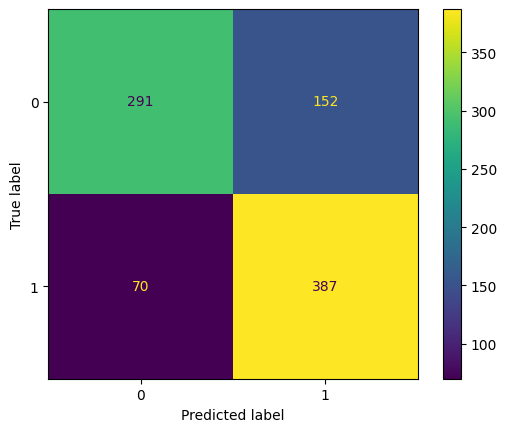

In [26]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
conf_mat = confusion_matrix(actual, predicted)

displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()